# Introduction

In this project, our group aims to predict rental prices for residential properties and apartments across Victoria, Australia. The primary objective is to investigate the influence of both internal and external factors on rental prices, while identifying properties most likely to see rent increases over the next five years. Internal variables such as the number of bedrooms will be examined alongside external factors like proximity to schools, transport, and population demographics.

Our group will scrape data from property listing websites, such as Domain, and utilize external datasets to perform analysis and this analysis will provide insights into:

1. Key features influencing rental price predictions.
2. Top 10 suburbs with the highest expected rent growth.
3. Most liveable and affordable suburbs according to defined metrics.




# Our Aim: 

In this project, our group aims to assist Purpose Built Student Accommodation (PBSA) providers in identifying new locations for rental developments, especially as changes in international student caps from 2025 onwards will incentivize further construction of PBSAs. 

With temporary higher education visa holders accounting for 33.9% of net overseas migration in FY 2022-23, the demand for student housing has significantly increased. Currently, PBSAs provide accommodation for over 76,500 students as of May 2022, but there is still unmet demand for more student housing.

Our analysis will focus on identifying the optimal locations for PBSA developments, ensuring they are positioned to meet the needs of international students and maximize growth potential in the rental market.

This project will leverage both geospatial data and rental market trends to ensure PBSA developers are equipped with the insights needed to make strategic decisions for future growth.


# Dataset and Preprocessing

The data used in this project comes from a variety of sources, including government datasets and web scraping efforts. Each dataset has been preprocessed separately to ensure quality and consistency before analysis. The preprocessing steps for each dataset are detailed in their individual notebooks.

## Datasets Used

1. **Australian Bureau of Statistics (ABS) Income Data**  
   - *Files*:  
     - `ABS_Income_including_government_allowances_by_2021_SA2_Nov_2023.csv`
     - `au-govt-abs-abs-data-by-region-income-asgs-sa2-2011-2019-sa2-2016.csv`  
   - These files provide regional income data, including government allowances, which are critical for understanding the financial landscape of different SA2 regions across Australia.

2. **Demographic Data from ABS**  
   - *File*:  
     - `33010DO002_2022_ST_AUST.xlsx`  
   - This dataset provides population and fertility data, which we use to project population growth and future housing demand, especially relevant for student accommodations.

3. **Geospatial Data (Shapefiles)**  
   - *File*:  
     - `SA2_2021_AUST_GDA2020.shp`  
   - This shapefile contains geographic boundary data for Statistical Areas Level 2 (SA2). It allows us to map our data spatially and perform location-based analysis.

4. **Crime Data**  
   - *Source*:  
     - Crime data obtained from [Crime Statistics Agency, Victoria](https://www.crimestatistics.vic.gov.au/crime-statistics/latest-victorian-crime-data/download-data)  
   - This dataset is used to analyze the impact of crime on rental prices and livability in different regions.

5. **Rental Data**  
   - *Source*:  
     - Scraped from domain.com.au  
   - Rental data is collected through web scraping efforts to gather information on current rental prices, property attributes, and availability.

## Preprocessing Steps

Each dataset underwent its own preprocessing steps to ensure that the data was ready for analysis. The preprocessing steps included tasks such as:

- **Cleaning**: Removing any missing or invalid data entries.
- **Transformation**: Standardizing units and formats for consistency.
- **Feature Engineering**: Creating new features such as distance to the nearest transportation, proximity to schools, or calculating rent price per square meter.
- **Merging**: Combining multiple datasets (e.g., income data, demographic data, and rental data) based on SA2 regions for a comprehensive analysis.

The detailed preprocessing steps can be found in their respective notebooks within the project repository.


# Modelling: Price

For the modelling phase of the project, we utilized a combined dataset, `model_data.parquet`, which integrates data from multiple sources such as rental prices, demographic information, crime rates, income data, and geospatial features. This dataset provided a comprehensive view, allowing us to build predictive models to forecast rental prices and identify key factors that influence price trends.


In [24]:
import pandas as pd
df = pd.read_parquet("model_data.parquet")
df.head()

,bedrooms,bathrooms,propertyTypes,carspaces,latitude,longitude,price,is_furnished,year,SA2_CODE21,...,date_numeric,median_income,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,[apartmentUnitFlat],0.0,-37.815016,144.965968,380.0,0,2011,206041503,...,14,NaN,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,[apartmentUnitFlat],1.0,-37.816257,144.953288,550.0,0,2011,206041505,...,16,NaN,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,[apartmentUnitFlat],0.0,-37.821294,144.955768,370.0,0,2011,206041505,...,16,NaN,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,[apartmentUnitFlat],1.0,-37.760855,144.961691,429.0,0,2011,206011495,...,30,NaN,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,[apartmentUnitFlat],1.0,-37.810074,144.985476,460.0,0,2011,206041119,...,44,NaN,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


## Data Preprocessing

Before building the models, several preprocessing steps were applied to clean and prepare the data:
- **Feature Selection**: We removed unnecessary columns, including `propertyTypes`, `days_on_market`, `longitude`, `latitude`, and `median_income`, to focus on relevant features for price prediction.
- **Outlier Removal**: We defined thresholds to remove outliers in features such as price, number of bedrooms, bathrooms, and car spaces. For instance, prices above the 99.5th percentile were considered outliers. After removing the outliers, the data was reduced to a more manageable and representative subset.
  
These steps helped improve the quality and reliability of the data used in the modelling process.

In [25]:
cleaned_df = df.copy()

cleaned_df.drop(columns=['propertyTypes'], inplace=True)
cleaned_df.drop(columns=['days_on_market'], inplace=True)
cleaned_df.drop(columns=['longitude'], inplace=True)
cleaned_df.drop(columns=['latitude'], inplace=True)
cleaned_df.drop(columns=['median_income'], inplace=True)


# Initial count of rows
initial_count = cleaned_df.shape[0]

# Define outlier thresholds
price_threshold = cleaned_df['price'].quantile(0.995)  # Example threshold for high prices
bedrooms_threshold = 6  # Example threshold for maximum bedrooms
bathrooms_threshold = 7  # Example threshold for maximum bathrooms
carspaces_threshold = 4  # Example threshold for maximum carspaces

# Remove outliers based on defined thresholds
filtered_df = cleaned_df[
    (cleaned_df['price'] <= price_threshold) &
    (cleaned_df['bedrooms'] <= bedrooms_threshold) &
    (cleaned_df['bathrooms'] <= bathrooms_threshold) &
    (cleaned_df['carspaces'] <= carspaces_threshold)
]

# Count of rows after filtering
filtered_count = filtered_df.shape[0]

# Print counts before and after
print(f"Initial number of rows: {initial_count}")
print(f"Number of rows after outlier removal: {filtered_count}")

filtered_df.head(5)

Initial number of rows: 120526
Number of rows after outlier removal: 119574


,bedrooms,bathrooms,carspaces,price,is_furnished,year,SA2_CODE21,population,distance_to_bus_stop,distance_to_train_stop,...,bed_bath_interaction,date_numeric,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,0.0,380.0,0,2011,206041503,7939,0.003576,0.003437,...,1.0,14,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,1.0,550.0,0,2011,206041505,7475,0.001879,0.002518,...,2.0,16,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,0.0,370.0,0,2011,206041505,7475,0.002997,0.005501,...,1.0,16,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,1.0,429.0,0,2011,206011495,11981,0.000593,0.001079,...,2.0,30,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,1.0,460.0,0,2011,206041119,5238,0.001944,0.006598,...,2.0,44,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


## Model Training

We employed several machine learning models to predict rental prices, with a primary focus on the **RandomForestRegressor**. The model was trained using a train-test split, ensuring that we could evaluate performance on unseen data. 

### Steps:
1. **Train-Test Split**: The data was split into training and testing sets where data from 2011-2023 was used as training to predict 2024 to ensure the model could generalize well to new data.
2. **Model Tuning**: We applied **GridSearchCV** to perform hyperparameter tuning on the RandomForestRegressor. This involved searching across various hyperparameters to find the best combination that minimized the Root Mean Squared Error (RMSE). A predefined split was used to ensure consistent evaluation.
3. **Cross-Validation**: A predefined cross-validation strategy was employed to evaluate the model's performance on the training and test sets across different runs, ensuring robustness.

### Final Model and Evaluation

After multiple runs and hyperparameter tuning, the best parameters for the RandomForestRegressor were selected based on the lowest RMSE score. The best model demonstrated strong performance, with a significant reduction in prediction error compared to baseline models.

The results from the final model were used to generate predictions for rental price trends and provide insights into the most important features influencing rental prices, such as proximity to transport and the number of bedrooms.


In [26]:
# Define the target variable and features
target = 'price'
features = [col for col in filtered_df.columns if col != target]

# Split the data into train and test sets
train_data = filtered_df[filtered_df['year'].between(2011, 2023)]
test_data = filtered_df[filtered_df['year'] == 2024]

X_train = train_data[features]
y_train = train_data[target]
X_test = test_data[features]
y_test = test_data[target]

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split, PredefinedSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from collections import Counter

# Assume you have separate training and evaluation datasets
# `X_train_full` and `y_train_full` are your 2023 data
# `X_test_full` and `y_test_full` are your 2024 data

# Sample 20% of the training data for each round of grid search
sample_fraction = 0.2

# Define the parameter grid for RandomForestRegressor
param_grid = {
    'n_estimators': [100, 200, 250],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt'],
    'bootstrap': [True, False]
}

# Store results from different random state runs
results = []
best_params_list = []

# Run multiple rounds of grid search with different random states for data sampling
for run in range(10):
    # Use different random states for each sampling round
    random_state_sample = np.random.randint(0, 1000)

    # Sample the training data
    X_train_sampled, _, y_train_sampled, _ = train_test_split(
        X_train, y_train, train_size=sample_fraction, random_state=random_state_sample
    )

    # Concatenate training and evaluation data to create a single dataset
    X_combined = pd.concat([X_train_sampled, X_test])
    y_combined = pd.concat([y_train_sampled, y_test])

    # Create a predefined split: -1 for train, 0 for test
    test_fold = [-1] * len(X_train_sampled) + [0] * len(X_test)
    ps = PredefinedSplit(test_fold)

    # Initialize the RandomForestRegressor model
    rf_reg = RandomForestRegressor(random_state=42)  # Random state here controls only reproducibility for the RF itself

    # Setup GridSearchCV with the predefined split
    grid_search = GridSearchCV(
        estimator=rf_reg, param_grid=param_grid,
        scoring='neg_root_mean_squared_error', cv=ps, n_jobs=-1, verbose=1
    )

    # Fit the model using the predefined train-test split
    grid_search.fit(X_combined, y_combined)

    # Store the results for this random state
    results.append({
        "random_state_sample": random_state_sample,
        "best_params": grid_search.best_params_,
        "best_score": -grid_search.best_score_  # Negative sign because `neg_root_mean_squared_error` is used
    })

    best_params_list.append(grid_search.best_params_)
    print(f"Run {run + 1}: Best parameters found: {grid_search.best_params_}")
    print(f"Run {run + 1}: Best RMSE score found: {-grid_search.best_score_}")

# Find the most common parameters across runs
most_common_params = Counter(tuple(sorted(p.items())) for p in best_params_list).most_common(1)
print("Most common hyperparameters across runs:", most_common_params)

In [28]:
# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

Root Mean Squared Error (RMSE) of Random Forest Regressor: 82.81


## Recursive Feature Elimination (RFE)

In our modelling process, we used **Recursive Feature Elimination (RFE)** to select the most important features for predicting rental prices. By using RFE, we optimized the model by selecting the best-performing subset of features, which helped reduce overfitting and enhanced the predictive accuracy of the RandomForest model. More detailed steps on how the top 12 features were obtained can be found in the modelling notebook. Here we simply define the top 12 features in selected_features_rfe.


In [29]:
# Define the target variable and features
target = 'price'
features = [col for col in filtered_df.columns if col != target]

train_data = filtered_df[filtered_df['year'].between(2011, 2024)]

X_train = train_data[features]
y_train = train_data[target]

test_data = pd.read_csv('/root/project-2-group-real-estate-industry-project-34/data/landing/test_data.csv')

In [30]:
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=10, n_estimators=250, random_state=42)

In [31]:
# Predict on the test data
test_data = test_data[X_train.columns]  # Ensure test_data has the same columns as X_train
test_data['predicted_target'] = rf_model.predict(test_data)

In [32]:
test_data.to_csv("test_data_priced.csv",index=False)

## Feature Importance

Using the Random Forest model, we identified the most important features that contribute to predicting rental prices. The model's feature importance scores help us understand which variables have the greatest impact on rental price predictions. Below are the key features and their relative importance:

- **bed_bath_interaction**: The interaction between the number of bedrooms and bathrooms proved to be the most important feature. This interaction captures the combined effect of these two factors, which strongly influence the overall price.
- **bathrooms**: The number of bathrooms directly impacts the perceived value of the property, making it a critical determinant of rental prices.
- **date_numeric**: The time factor, represented as a numeric value, also plays a significant role in predicting price trends, capturing temporal changes in the market.
- **bedrooms**: Similar to bathrooms, the number of bedrooms is another key internal feature that significantly affects rental pricing.
- **distance_to_CBD**: Proximity to the Central Business District (CBD) is an external feature that greatly influences the desirability and price of a property.
- **distance_to_tram_stop**: Being located near a tram stop adds convenience and increases the rental value of a property.
- **distance_to_uni**: The closer a property is to universities, the more desirable it becomes for students, driving up rental prices.
- **SA2_CODE21**: This feature represents the geographic SA2 regions, accounting for location-based factors that impact rent.
- **Income (Median)**: Median income levels in the area contribute to pricing decisions, as more affluent areas can sustain higher rental rates.

Other features such as **carspaces**, **distance to public transport (train, bus)**, and **proximity to malls or supermarkets** also play a role but are less important compared to the top factors listed above.

This analysis helps us understand that both internal property attributes (e.g., bedrooms, bathrooms) and external location-based factors (e.g., distance to CBD and transport hubs) are crucial in determining rental prices. The Random Forest model effectively highlights the relative importance of these features.


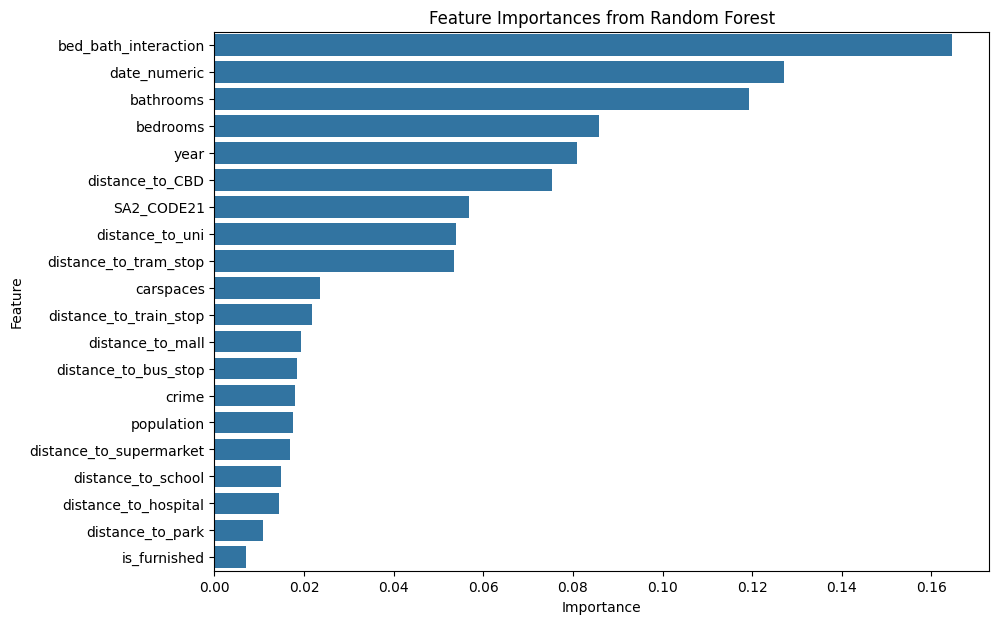

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns


# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

## Predicting SA2s with the Highest Growth

To identify the top suburbs with the highest predicted rental price growth, we used the trained model to forecast rental prices for the years 2025, 2026, and 2027 across various SA2 regions. We then calculated the percentage growth for each SA2 by comparing the predicted prices from 2025 to 2027.

The top SA2 districts with the highest predicted rental price growth from 2025 to 2027 are:

- **Dandenong - North** (SA2_CODE21: 210051445) with a predicted growth of **1.10656%**
- **Mickleham - Yuroke** (SA2_CODE21: 209041528) with a predicted growth of **0.92941%**
- **Sorell - South** (SA2_CODE21: 206041506) with a predicted growth of **0.46127%**

These areas are expected to see the highest percentage increases in rental prices, making them prime targets for investment and development. The growth predictions are based on multiple factors, including population forecasts, current rental trends, and proximity to amenities and transport.


In [34]:
import pandas as pd
from tabulate import tabulate

# Load population data (or suburb data)
population_df = pd.read_csv('/root/project-2-group-real-estate-industry-project-34/data/landing/forecasted_populations.csv')

# Ensure 'SA2_CODE21' is numeric
population_df['SA2_CODE21'] = pd.to_numeric(population_df['Code'], errors='coerce')
test_data['SA2_CODE21'] = pd.to_numeric(test_data['SA2_CODE21'], errors='coerce')

# Drop NaN values and duplicates
population_df = population_df.dropna(subset=['SA2_CODE21']).drop_duplicates(subset='SA2_CODE21')

# Create a DataFrame for 2025, 2026, and 2027 prices
pivot_data = test_data.pivot_table(
    index='SA2_CODE21',
    columns='year',
    values='predicted_target'
).reset_index()

# Rename the columns for clarity
pivot_data.columns.name = None  # Remove the column index name
pivot_data.columns = ['SA2_CODE21', 'predicted_price_2025', 'predicted_price_2026', 'predicted_price_2027']

# Calculate actual growth and percentage growth for each SA2
pivot_data['actual_growth'] = pivot_data['predicted_price_2027'] - pivot_data['predicted_price_2025']
pivot_data['percentage_growth'] = (pivot_data['actual_growth'] / pivot_data['predicted_price_2025']) * 100

# Group by SA2_CODE21 to calculate average growth metrics
sa2_growth = pivot_data.groupby('SA2_CODE21').agg({
    'predicted_price_2025': 'mean',
    'predicted_price_2026': 'mean',
    'predicted_price_2027': 'mean',
    'actual_growth': 'mean',
    'percentage_growth': 'mean'
}).reset_index()

# Convert SA2_CODE21 to string to avoid scientific notation
sa2_growth['SA2_CODE21'] = sa2_growth['SA2_CODE21'].astype(int)

# Calculate the count of properties in the training data for each SA2
train_property_counts = train_data.groupby('SA2_CODE21').size().reset_index(name='property_count')

train_property_counts['SA2_CODE21'] = train_property_counts['SA2_CODE21'].astype(int)

# Merge the property count with sa2_growth data
sa2_growth_with_count = sa2_growth.merge(train_property_counts, on='SA2_CODE21', how='left')

# Merge with suburb names
sa2_growth_with_suburb = sa2_growth_with_count.merge(
    population_df[['SA2_CODE21', 'Suburb']], 
    on='SA2_CODE21', 
    how='left'
)

# Sort the districts by the calculated percentage growth
sa2_growth_with_suburb = sa2_growth_with_suburb.sort_values(by='percentage_growth', ascending=False)

# Output the SA2 districts with the highest predicted growth in listing prices using tabulate
print("SA2 districts with the highest predicted actual growth in listing prices from 2025 to 2027 (including property counts):")
print(tabulate(sa2_growth_with_suburb, headers='keys', tablefmt='psql', showindex=False))

SA2 districts with the highest predicted actual growth in listing prices from 2025 to 2027 (including property counts):
+--------------+------------------------+------------------------+------------------------+-----------------+---------------------+------------------+-----------------------------------------------+
|   SA2_CODE21 |   predicted_price_2025 |   predicted_price_2026 |   predicted_price_2027 |   actual_growth |   percentage_growth |   property_count | Suburb                                        |
|--------------+------------------------+------------------------+------------------------+-----------------+---------------------+------------------+-----------------------------------------------|
|    212041563 |                509.739 |                511.846 |                515.916 |     6.177       |         1.2118      |              151 | Dandenong - North                             |
|    210051445 |                484.089 |                488.067 |                48

## Modelling Demand

After successfully modelling rental prices, we shifted our focus to modelling **demand** for rental properties. The process of modelling demand follows a similar approach to the one we used for predicting rental prices, with the primary difference being the target variable.




In [35]:
df = pd.read_parquet("/root/project-2-group-real-estate-industry-project-34/data/landing/model_data.parquet")

In [37]:
cleaned_df = df.copy()

cleaned_df.drop(columns=['propertyTypes'], inplace=True)
cleaned_df.drop(columns=['longitude'], inplace=True)
cleaned_df.drop(columns=['latitude'], inplace=True)
cleaned_df.drop(columns=['median_income'], inplace=True)


# Initial count of rows
initial_count = cleaned_df.shape[0]

# Define outlier thresholds
price_threshold = cleaned_df['price'].quantile(0.995)  # Example threshold for high prices
bedrooms_threshold = 6  # Example threshold for maximum bedrooms
bathrooms_threshold = 7  # Example threshold for maximum bathrooms
carspaces_threshold = 4  # Example threshold for maximum carspaces

# Remove outliers based on defined thresholds
filtered_df = cleaned_df[
    (cleaned_df['price'] <= price_threshold) &
    (cleaned_df['bedrooms'] <= bedrooms_threshold) &
    (cleaned_df['bathrooms'] <= bathrooms_threshold) &
    (cleaned_df['carspaces'] <= carspaces_threshold)
]

# Count of rows after filtering
filtered_count = filtered_df.shape[0]

# Print counts before and after
print(f"Initial number of rows: {initial_count}")
print(f"Number of rows after outlier removal: {filtered_count}")

filtered_df.head(5)

Initial number of rows: 120526
Number of rows after outlier removal: 119574


,bedrooms,bathrooms,carspaces,price,is_furnished,year,SA2_CODE21,days_on_market,population,distance_to_bus_stop,...,bed_bath_interaction,date_numeric,distance_to_hospital,distance_to_supermarket,distance_to_park,distance_to_mall,distance_to_CBD,distance_to_school,distance_to_uni,crime
0,1.0,1.0,0.0,380.0,0,2011,206041503,NaN,7939,0.003576,...,1.0,14,0.001411,0.002191,0.004031,0.000796,0.003437,0.005759,0.006994,1266.438330
1,2.0,1.0,1.0,550.0,0,2011,206041505,NaN,7475,0.001879,...,2.0,16,0.003685,0.002027,0.002119,0.000581,0.013828,0.003552,0.013897,1192.420522
2,1.0,1.0,0.0,370.0,0,2011,206041505,NaN,7475,0.002997,...,1.0,16,0.005240,0.003146,0.000254,0.005058,0.011588,0.008511,0.015817,1192.420522
3,2.0,1.0,1.0,429.0,0,2011,206011495,NaN,11981,0.000593,...,2.0,30,0.001683,0.001678,0.001734,0.014051,0.057691,0.010984,0.035241,820.152825
4,2.0,1.0,1.0,460.0,0,2011,206041119,NaN,5238,0.001944,...,2.0,44,0.000471,0.000370,0.000689,0.009837,0.020259,0.008693,0.020980,835.571731


In [38]:
days_threshold = filtered_df["days_on_market"].quantile(0.995)
# Filter the DataFrame to include only rows where days_on_market is >= 0 and <= days_threshold
filtered_df = filtered_df[(filtered_df["days_on_market"] >= 0) & (filtered_df["days_on_market"] <= days_threshold)]

In [55]:
# Define the target variable and features
target = 'days_on_market'
features = [col for col in filtered_df.columns if col != target]

train_data = filtered_df[filtered_df['year'].between(2011, 2024)]

X_train = train_data[features]
y_train = train_data[target]

test_data = pd.read_csv('/root/project-2-group-real-estate-industry-project-34/data/landing/test_data_priced.csv')

In [50]:
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)
rf_model.fit(X_train, y_train)

test_data["price"] = test_data["predicted_target"]
test_data = test_data[X_train.columns]  # Ensure test_data has the same columns as X_train
test_data['predicted_target'] = rf_model.predict(test_data)

In [54]:
# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=2, min_samples_split=5, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=250, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=2, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

# Train the Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=300, bootstrap=False, max_depth=5, max_features='sqrt', min_samples_leaf=4, min_samples_split=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and compute RMSE
y_pred = rf_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Root Mean Squared Error (RMSE) of Random Forest Regressor: {rmse:.2f}")

Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.15
Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.15
Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.15
Root Mean Squared Error (RMSE) of Random Forest Regressor: 18.16


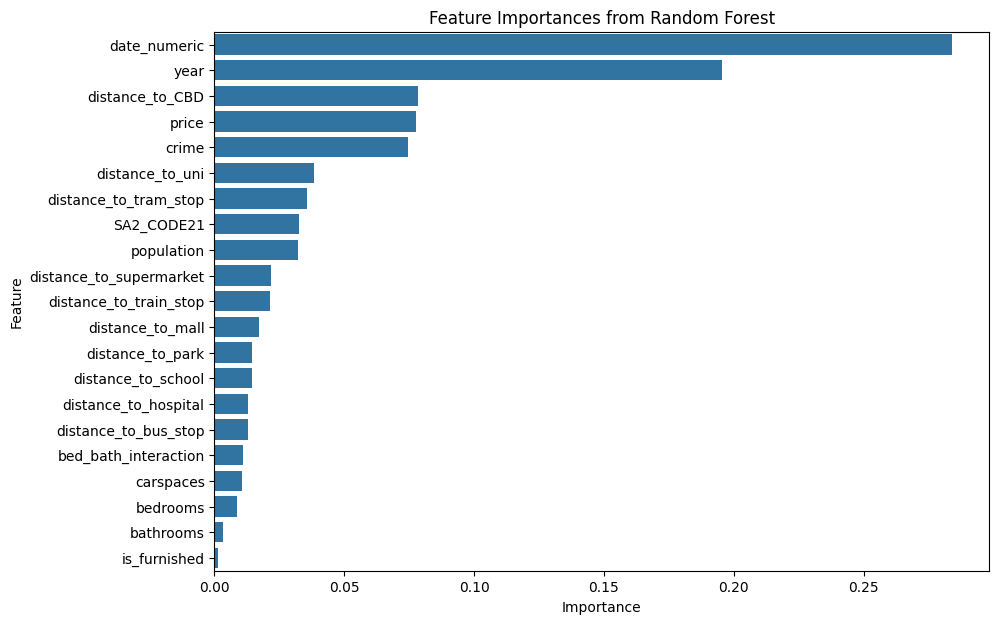

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns


# Feature Importance from Random Forest
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10,7))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances from Random Forest')
plt.show()

## Predicting SA2s with the Highest Demand

To identify the top suburbs with the highest predicted demand, we created a model similar to the model used to predict the fastest growing SA2s above.

The top 10 SA2 districts with the highest demand from 2025 to 2027 are shown in the table below. Further modelling steps can be read in the respective notebook.




## SA2 Districts with the Lowest Predicted Days on Market in 2027

| SA2_CODE21   | Predicted Days 2023 | Predicted Days 2024 | Predicted Days 2025 | Predicted Days 2026 | Predicted Days 2027 | Days on Market Change | Percentage Change Days | Property Count | Suburb                                        |
|--------------|---------------------|---------------------|---------------------|---------------------|---------------------|-----------------------|------------------------|----------------|------------------------------------------------|
| 206051128    | 30.931              | 24.95               | 31.2011             | 31.2011             | 31.2011             | 0                     | 0                      | 394            | Albert Park                                   |
| 206071143    | 22.2308             | 26.725              | 31.2673             | 31.2673             | 31.2673             | 0                     | 0                      | 264            | Fitzroy North                                 |
| 206071142    | 24.0882             | 30.8966             | 31.4265             | 31.4265             | 31.4265             | 0                     | 0                      | 127            | Fitzroy                                       |
| 206041510    | 27.6452             | 21.7778             | 31.8197             | 31.8197             | 31.8197             | 0                     | 0                      | 421            | West Melbourne - Residential                  |
| 206061136    | 30.9634             | 23.6782             | 31.8434             | 31.8434             | 31.8434             | 0                     | 0                      | 411            | Prahran - Windsor                             |
| 206041506    | 32.7976             | 20.3776             | 31.8912             | 31.8912             | 31.8912             | 0                     | 0                      | 488            | North Melbourne                               |
| 206051513    | 23.2188             | 22.7805             | 31.9325             | 31.9325             | 31.9325             | 0                     | 0                      | 453            | St Kilda - Central                            |
| 206071141    | 22.2414             | 27.7                | 31.9458             | 31.9458             | 31.9458             | 0                     | 0                      | 112            | Collingwood                                   |
| 206041118    | 24.3148             | 25.7879             | 31.9115             | 31.9115             | 32.0388             | 0.127317              | 0.398968               | 783            | Docklands                                     |
| 206011496    | 21.0781             | 22.3171             | 32.1663             | 32.1663             | 32.1663             | 0                     | 0                      | 275            | Brunswick - South                             |


These areas are expected to experience the highest demand in the coming years, making them attractive options for developers and investors. The predictions are based on several factors, including low predicted days on market for example and their appeal to both renters and buyers ensures continued interest and growth.

## Recommendations

While the individual data points and models provide valuable insights, it's when they are put together that we can make informed, strategic recommendations for your next development project. Based on our analysis, we have crafted some specific recommendations that we believe could be highly beneficial in choosing the location of your next development.

### Targeting the Lifestyle-Oriented Market

If your focus is on attracting a **lifestyle-oriented market**, we recommend considering areas such as **North Melbourne** and **Docklands**. Our models indicate that both of these areas rank in the top 10 for projected rental growth, and North Melbourne is also in the top 10 for both **demand** and **liveability**. While Docklands falls just outside the top 10 in some of these categories, it still presents a strong opportunity.

Although both areas are intriguing, we would **lean towards North Melbourne** due to its stronger performance in demand and liveability metrics, making it an ideal target for new developments aimed at young professionals and families seeking a balanced lifestyle close to the city.

### Build-to-Rent Opportunity

As you consider your next project, a key question might be whether to develop a **build-for-sale** or **build-to-rent (BTR)** property. We encourage you to diversify your portfolio by strongly considering a **build-to-rent** development. Melbourne has seen several successful BTR projects in recent years, including:
- **Liv Munro**
- **Liv Aston**
- **Home**
- **Platinum Apartments**

All of these are located close to the CBD, and there is a **huge opportunity** to develop something similar in **Docklands** or **North Melbourne**, where there is still untapped potential. Building a BTR development in these areas allows you to establish a project before your competitors, securing a first-mover advantage.

### Constant Demand from Renters

The presence of **students** and **young professionals** in these areas bodes well for maintaining a constant influx of renters. With students frequently looking for rental options and young professionals increasingly renting due to difficulties in obtaining a mortgage, the demand for rental properties is expected to remain strong. This makes areas like North Melbourne and Docklands ideal for long-term investments in rental properties.

### Why Build-to-Rent?

A **BTR development** not only attracts renters but also offers the advantage of providing a **constant income stream**, unlike traditional build-for-sale projects that generate one-off sales. This approach diversifies a developer's portfolio and creates a more sustainable, recurring revenue model. With rising demand for rental properties and limited competition in BTR developments in these areas, the time is right to capitalize on this opportunity.

In summary, based on our data-driven analysis, **North Melbourne** and **Docklands** present prime opportunities for your next **lifestyle-oriented** and **build-to-rent** development, ensuring both high demand and long-term growth potential.
